In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

import analyze2p.decoding as dec

In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)

In [4]:
%matplotlib notebook

In [5]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [6]:
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'

experiment = 'blobs'
response_type='dff'
responsive_test='nstds'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
trial_epoch='plushalf' #'stimulus'
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                if not meta.query('@va == visual_area and @dk == datakey').empty])
# Neural data
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 

traces001|dff_responsive-nstds-thr10.00
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15.0 0.0], y: [-5.0 0.0]


In [7]:
import _pickle as pkl

# Example BY_NCELLS

#### Test sampling

In [8]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [9]:
n_cells_sample=4

In [17]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [20]:
cells0 = dec.get_all_responsive_cells(cells0, NDATA0)
# gcells = aggr.assign_global_cell_ids(cells0)
# dkey_lut = NDATA0[['visual_area', 'datakey', 'cell']].drop_duplicates()
# cells0 = pd.concat([gcells[(gcells.visual_area==va) \
#              & (gcells.datakey==dk) & (gcells['cell'].isin(g['cell'].unique()))]\
#             for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])])


# With RFs

In [127]:
import analyze2p.receptive_fields.utils as rfutils

In [47]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [48]:
rf_lim = 'percentile'
# cells_lim = dec.get_cells_with_matched_rfs(cells0, sdata, rf_lim='percentile')
rfdf = dec.get_rfdf(cells0, sdata, do_spherical_correction=False)
cells_RF = dec.get_cells_with_rfs(cells0, rfdf)
cells_lim, sz_limits = dec.limit_cells_by_rf(cells_RF, rf_lim=rf_lim)

N dpaths: 62, N unfit: 0
N datasets included: 62, N sessions excluded: 4


In [26]:
print(cells_RF[['visual_area', 'datakey', 'cell']].drop_duplicates()\
      ['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |           603 |
| Lm |           342 |
| Li |           244 |


In [50]:

sz_lower, sz_upper = sz_limits.loc['lower'].max(), lims.loc['upper'].min()
sz_limits

,Li,Lm,V1
lower,5.465634,1.976085,3.460627
upper,22.869264,20.914859,14.470901


In [54]:
dst_dir = os.path.join(aggregate_dir, 'decoding', 'py3_by_ncells')

<IPython.core.display.Javascript object>


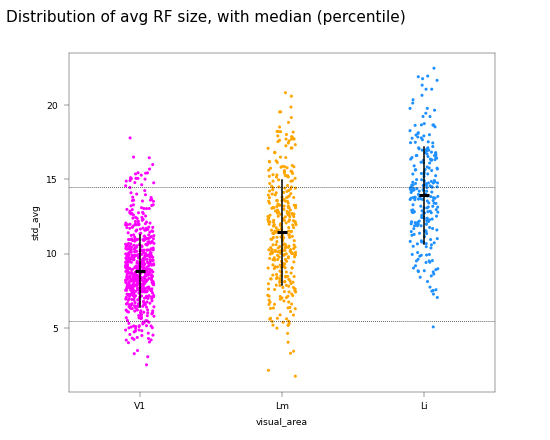

In [57]:
%matplotlib notebook
fig, ax = pl.subplots(figsize=(5,4))
sns.stripplot(x='visual_area', y='std_avg', hue='visual_area', 
             data=cells_RF, ax=ax, order=visual_areas, 
             palette=area_colors, s=2, zorder=0)
sns.pointplot(x='visual_area', y='std_avg',
             data=cells_RF, ax=ax, order=visual_areas, join=False, ci='sd',
             estimator=np.median, color='k', markers='_', scale=1, zorder=1000,
             errwidth=1)

# sz_upper_lim=16.6
# sz_lower_lim=6.9
ax.axhline(y=sz_lower, color='k', ls=':', lw=0.5)
ax.axhline(y=sz_upper, color='k', ls=':', lw=0.5)
ax.legend_.remove()

fig.text(0.01, 0.95, 'Distribution of avg RF size, with median (%s)' % rf_lim)

pl.savefig(os.path.join(dst_dir, 'RF_sizes_%s.svg' % rf_lim))


In [58]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells'

In [64]:
import analyze2p.objects.sim_utils as su

In [458]:
importlib.reload(su)

<module 'analyze2p.objects.sim_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py'>

<IPython.core.display.Javascript object>


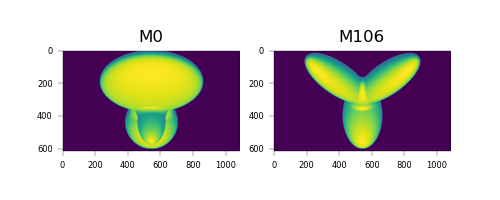

In [459]:
m1 = 'M%i' % 0
m2 = 'M%i' % 106
#images, impaths = su.load_stimuli(root='/n/home00/juliana.rhee', return_paths=True)
#print("im shape:", images['M0'].shape)
images = su.load_stimuli()
f, axn = pl.subplots(1,2, figsize=(5,2))
axn[0].imshow(images[m1]); axn[0].set_title(m1);
axn[1].imshow(images[m2]); axn[1].set_title(m2);



In [370]:
dk = '20190602_JC091_fov1'
va='Li'
experiment='blobs'

In [372]:
# stim_xpos, stim_ypos = aggr.get_stimulus_coordinates(dk, experiment)
# sdf = aggr.get_stimuli(dk, experiment, match_names=True)
# stim_sizes = sorted(sdf['size'].unique())

20.0 -8.0


In [598]:
importlib.reload(su)

<module 'analyze2p.objects.sim_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py'>

<IPython.core.display.Javascript object>


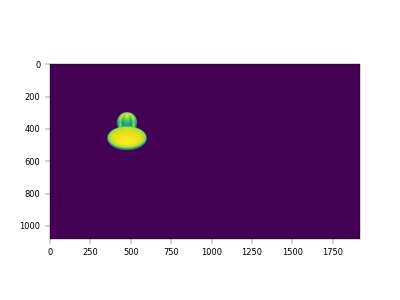

In [380]:
%matplotlib notebook
img_ix = 0

pl.figure(figsize=(4,3))
pl.imshow(stim_screen)

In [602]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
curr_rfs = rfdf[(rfdf.visual_area==va) * (rfdf.datakey==dk)].copy()
print(len(curr_rfs))

68


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [603]:
curr_rfs.columns

Index(['x0', 'y0', 'fwhm_x', 'fwhm_y', 'theta', 'offset', 'amplitude', 'r2',
       'cell', 'datakey', 'animalid', 'session', 'fovnum', 'visual_area',
       'experiment', 'std_x', 'std_y', 'fwhm_avg', 'std_avg', 'area', 'fx',
       'fy', 'ratio_xy', 'theta_c', 'theta_Mm_deg', 'major_axis', 'minor_axis',
       'anisotropy', 'theta_Mm_c', 'aniso_index'],
      dtype='object')

<IPython.core.display.Javascript object>


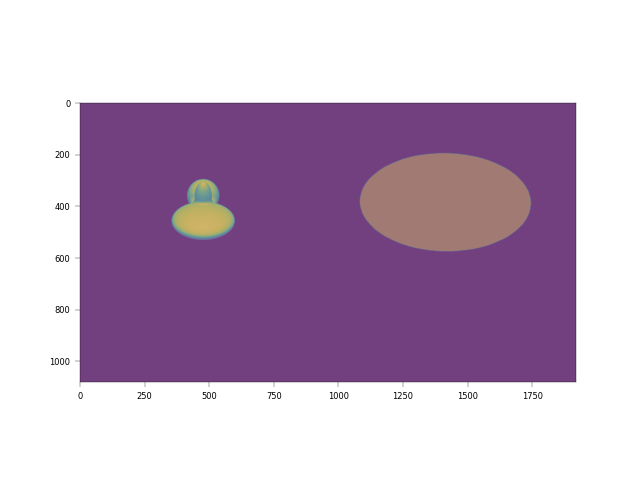

In [381]:
rid = 15
rfs_ = params_deg_to_pixels(curr_rfs)
rf_screen = su.rf_to_screen(rid, rfs_, resolution=screen_res)

pl.figure()
pl.imshow(rf_mask, alpha=0.5)
pl.imshow(stim_screen, alpha=0.5)

In [382]:
rf_screen.shape, stim_screen.shape

((1080, 1920), (1080, 1920))

In [609]:
importlib.reload(su)

<module 'analyze2p.objects.sim_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/sim_utils.py'>

In [610]:
rid=15
rf_screen = su.rf_to_screen(rid, curr_rfs, resolution=[1920, 1080])


<IPython.core.display.Javascript object>


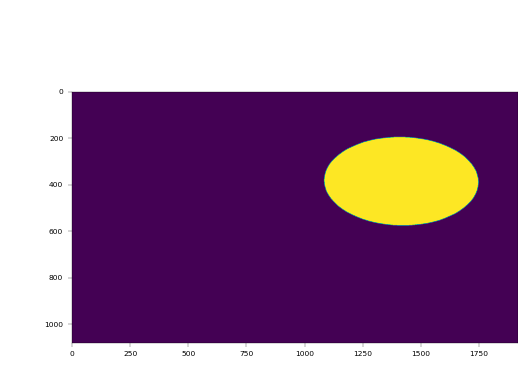

In [611]:
%matplotlib notebook
pl.figure()
pl.imshow(rf_screen)

In [ ]:
curr_rfs = rfdf[]

In [383]:
rf = su.image_to_poly(rf_screen)
blob = su.image_to_poly(stim_screen.astype(np.uint8))
odf = rfutils.calculate_overlap(rf, blob, r1='rf', r2='blob')

In [384]:
odf


,poly1,poly2,area_overlap,perc_overlap
0,rf,blob,0.0,0.0


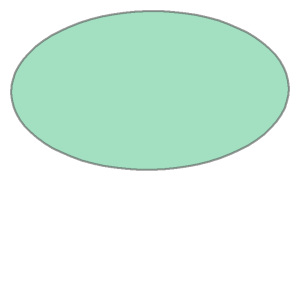

In [386]:
rf

In [148]:

# Concatenate into dataframe
rf_polys = rfutils.rfs_to_polys(curr_rfs[rf_fit_params])
# Convert stimuli to polyon bounding boxes
stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
                  for blob_sz in stim_sizes]

perc_overlap = pd.concat([rfutils.get_proportion_overlap(rf_poly, stim_poly) \
                for stim_poly in stim_polys for rf_poly in rf_polys.items()])\
        .rename(columns={'row': 'cell', 'col': 'stim_size'})

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


68


In [153]:
min_overlaps = perc_overlap.groupby(['cell'])['perc_overlap'].min().reset_index()

In [158]:
min_overlaps.shape, min_overlaps[min_overlaps['perc_overlap']>=.8].shape

((68, 2), (42, 2))

In [167]:
min_overlaps

,cell,perc_overlap
0,15.0,0.834035
1,16.0,0.863217
2,22.0,0.975547
3,23.0,0.795617
4,27.0,0.857942
...,...,...
63,335.0,0.639897
64,336.0,0.808836
65,338.0,0.852620
66,346.0,0.892320


<IPython.core.display.Javascript object>


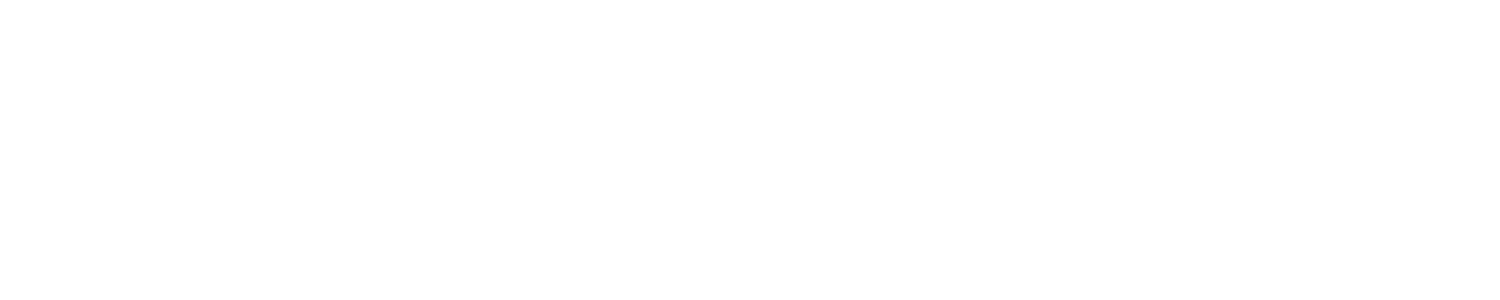

KeyError: 0

In [159]:
fig, axn = pl.subplots(1,5, figsize=(15,3))

p_rf = rf_polys[0][1]

p_stim = stim_polys[0]
for stim_ix, p_stim in enumerate(stim_polys):
    ax = axn[stim_ix]

    #perc_overlap = rfutils.get_proportion_overlap(rf_polys[0], (5stim_ix, p_stim))
    perc_overlap = rfutils.get_proportion_overlap(rf_poly, p_stim) 
    
    #print(perc_overlap)rfutils.get_proportion_overlap(rf_poly, stim_poly)

    x, y = p_rf.exterior.xy
    ax.plot(x, y)
    ax.set_title(perc_overlap['perc_overlap'].values, fontsize=8)
    print(stim_ix, perc_overlap['perc_overlap'].values)

    x, y = p_stim[1].exterior.xy
    ax.plot(x, y)
    ax.set_aspect('equal')
    
pl.subplots_adjust(wspace=0.5)

In [37]:
(50*1.5) + 50

125.0

In [297]:
lims

,Li,Lm,V1
lower,5.465634,1.976085,3.460627
upper,22.869264,20.914859,14.470901


In [284]:
sz_lower_lim

5.465634448925621

In [287]:
cells_lim = cells_RF[(cells_RF['std_avg']<=sz_upper_lim) 
                & (cells_RF['std_avg']>=sz_lower_lim)].copy()
print(cells_lim[['visual_area', 'datakey', 'cell']].drop_duplicates()\
      ['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |           545 |
| Lm |           260 |
| Li |           137 |


In [213]:
sz_upper_lim = cells_RF.groupby('visual_area')['std_avg'].max().min()
sz_lower_lim = cells_RF.groupby('visual_area')['std_avg'].min().max()

print(sz_upper_lim, sz_lower_lim)

17.793652808557802 5.095241274834805


# Example BY_FOV

In [7]:
print(experiment)
dk = '20190315_JC070_fov1'
va = 'Li'

nmetrics = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk)].copy()

blobs


In [9]:
# stimuli
sdf = aggr.get_stimuli(dk, experiment)
# zscore data
ndf_z = aggr.get_zscored_from_ndf(nmetrics)
n_cells = int(ndf_z.shape[1]-1) 
print("... BY_FOV [%s] %s, n=%i cells" % (va, dk, n_cells))

... BY_FOV [Li] 20190315_JC070_fov1, n=96 cells


In [597]:
# def shuffle_trials(ndf_z):
#     rois_ = [r for r in ndf_z.columns if hutils.isnumber(r)]
#     c_=[]
#     for cfg, cg in ndf_z.groupby(['config']):
#         n_trials = cg.shape[0]
#         cg_r = pd.concat([cg[ri].sample(n=n_trials, replace=False)\
#                           .reset_index(drop=True) for ri in rois_], axis=1)
#         cg_r['config'] = cfg
#         c_.append(cg_r)
#     ndf_r = pd.concat(c_, axis=0).reset_index(drop=True)
#     return ndf_r

In [10]:
ndf_z = dec.shuffle_trials(ndf_z)
ndf_z.head()


,85,86,99,102,103,104,109,110,113,114,...,265,272,275,277,285,286,289,294,305,config
0,0.657448,0.922816,-0.080056,-0.637012,0.334415,0.226142,-0.598845,-0.196968,-0.476377,1.036601,...,0.186279,0.520104,0.995994,-0.220327,1.806564,-0.611657,-0.579465,0.277990,1.131489,config006
1,0.063059,0.386268,-2.398410,0.859398,0.905894,1.232953,3.844114,-0.823735,0.489602,0.457975,...,-1.187366,0.922408,0.252722,0.680650,0.914599,0.438503,0.967195,1.033680,-0.893102,config006
2,-0.489989,-0.192296,1.168717,-1.293583,0.253939,-0.015068,-0.313985,-0.635917,-1.133025,0.724058,...,0.396453,2.044289,-0.422468,1.093920,-0.728285,-0.032370,-0.657708,0.293848,-0.702327,config006
3,-2.004870,0.973640,0.347264,0.079610,0.999251,0.007152,3.048734,-0.310361,-0.146608,0.429898,...,-0.910199,1.928157,-0.826398,-1.571665,1.720723,0.594625,-1.209503,-1.361571,0.694712,config006
4,-0.760196,0.332716,-0.237906,-0.028379,-1.252952,-0.324110,0.055510,-0.710998,0.510554,-0.754378,...,1.606730,0.334918,0.457971,-0.438136,-0.175090,-0.795792,-0.779229,2.216649,0.627952,config006


In [11]:
cfgs = ndf_z['config'].values
n_trials=ndf_z.shape[0]
rois_ = [r for r in ndf_z.columns if hutils.isnumber(r)]
#ndf_r = pd.concat([ndf_z[ri].sample(n=n_trials, replace=False) for ri in rois_])
#ndf_r['config'] = cfgs


In [14]:
C_value=1.0
test_split=0.2
cv_nfolds=5
n_iterations = 1
n_processes=1

class_name='morphlevel' if experiment=='blobs' else 'ori'
class_a = 0 if class_name=='morphlevel' else None
class_b = 106 if class_name=='morphlevel' else None
print(class_name, class_a, class_b)

class_values = [class_a, class_b] if class_name=='morphlevel' \
            else sdf[class_name].unique()
class_values

variation_name=None
variation_values=None

morphlevel 0 106


In [15]:
clf_params={'class_name': class_name,
            'class_values': class_values,
            'variation_name': variation_name,
            'variation_values': variation_values,
            'n_train_configs': None,
            'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'balance_configs':True,
            'do_shuffle': True,
            'return_clf': False,
            'verbose': False}

In [16]:
import copy
inargs = copy.copy(clf_params)


In [17]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [21]:
inum=3
break_correlations=False
test_type=None
i_df = dec.select_test(inum, test_type, ndf_z, sdf, break_correlations, **inargs)
i_df

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/sklearn/svm/_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/sklearn/svm/_base.py", line 560, in _validate_targets
    " class" % len(cls))
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The sc

In [49]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [57]:
sdf = aggr.get_stimuli(dk, experiment, match_names=True)

In [538]:
neuraldf = ndf_z.copy()
tvals = neuraldf.index.tolist()
neuraldf.loc[neuraldf.index, 'trial'] = tvals         


In [526]:
res = dec.fit_svm_mp(ndf_z, sdf, None, n_iterations=10, n_processes=1,
              **clf_params)

... 0 - selecting
--> Elapsed time: 12.50sec
... 1 - selecting
--> Elapsed time: 12.42sec
... 2 - selecting
--> Elapsed time: 12.68sec
... 3 - selecting
--> Elapsed time: 11.49sec
... 4 - selecting
--> Elapsed time: 13.12sec
... 5 - selecting
--> Elapsed time: 12.25sec
... 6 - selecting
--> Elapsed time: 12.25sec
... 7 - selecting
--> Elapsed time: 11.91sec
... 8 - selecting
--> Elapsed time: 11.87sec
... 9 - selecting
--> Elapsed time: 12.10sec


In [533]:
res[['train_score', 'test_score', 'heldout_test_score', 'condition']].groupby(['condition']).describe()

train_score                                                    \
                count      mean       std       min       25%       50%   
condition                                                                 
data             10.0  0.840819  0.010435  0.827876  0.831909  0.839475   
shuffled         10.0  0.616845  0.010824  0.597910  0.614318  0.617431   

                              test_score            ...                      \
                75%       max      count      mean  ...       75%       max   
condition                                           ...                       
data       0.848389  0.859373       10.0  0.258572  ...  0.265328  0.275371   
shuffled   0.621334  0.634036       10.0  0.124227  ...  0.133576  0.138661   

          heldout_test_score                                                   \
                       count      mean       std      min       25%       50%   
condition                                                                       
data                    10.0  0.273828  0.030002  0.21875  0.254883  0.275391   
shuffled                10.0  0.129688  0.023567  0.09375  0.110352  0.136719   

                               
                75%       max  
condition                      
data       0.294922  0.320312  
shuffled   0.146484  0.160156  

[2 rows x 24 columns]

In [365]:
inum =2
res = dec.do_fit_within_fov(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_a=class_a, class_b=class_b, 
                     do_shuffle=True, balance_configs=True, return_clf=False)


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:1182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_trial_col = True


In [376]:
# inum =2
# res = dec.train_test_size

In [436]:
inum =2
class_name='morphlevel'
class_values = [0, 106]
variation_name='size'
variation_values = sorted(sdf[variation_name].unique())

res = dec.train_test_size_subset(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_values=class_values,
                     variation_name=variation_name,
                     variation_values=variation_values,
                     n_train_configs=4,
                     do_shuffle=True, balance_configs=True, return_clf=False)


In [437]:
res

,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells
0,0.006387,0.000969,0.706091,1.0,0.040743,0.045418,0.058780,0.641509,1.0,7228,data,10_20_30_40,10_20_30_40,264,False,2,221
1,0.008795,0.001038,0.492802,1.0,0.022424,0.019121,0.032351,0.396226,1.0,7228,shuffled,10_20_30_40,10_20_30_40,264,False,2,221
2,0.006387,0.000969,0.706091,1.0,0.084611,0.119522,0.122068,0.686567,1.0,7228,data,10_20_30_40,50.0,67,True,2,221
3,0.006277,0.000910,0.663677,1.0,0.102707,0.137532,0.148175,0.716981,1.0,9823,data,10_20_30_50,10_20_30_50,264,False,2,221
4,0.007357,0.000959,0.502436,1.0,0.000147,-0.014046,0.000213,0.490566,1.0,9823,shuffled,10_20_30_50,10_20_30_50,264,False,2,221
5,0.006277,0.000910,0.663677,1.0,0.111929,0.152264,0.161479,0.731343,1.0,9823,data,10_20_30_50,40.0,67,True,2,221
6,0.005600,0.000857,0.682835,1.0,0.001548,-0.011960,0.002234,0.528302,1.0,5767,data,10_20_40_50,10_20_40_50,264,False,2,221
7,0.008921,0.001029,0.426135,1.0,0.004288,-0.008155,0.006187,0.547170,1.0,5767,shuffled,10_20_40_50,10_20_40_50,264,False,2,221
8,0.005600,0.000857,0.682835,1.0,0.046699,0.058313,0.067372,0.647059,1.0,5767,data,10_20_40_50,30.0,68,True,2,221
9,0.005312,0.000805,0.668217,1.0,0.052276,0.062297,0.075418,0.660377,1.0,1688,data,10_30_40_50,10_30_40_50,264,False,2,221


In [430]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [431]:
inum =2
class_name='morphlevel'
class_values = [0, 106]
variation_name='size'
variation_values = sorted(sdf[variation_name].unique())

res = dec.train_test_size_single(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_values=class_values,
                     variation_name=variation_name,
                     variation_values=variation_values,
                     n_train_configs=4,
                     do_shuffle=True, balance_configs=True, return_clf=False)


1.0
(4,)
1.0
(4,)
0.610909090909091
(4,)
0.0020420074462890623
(4,)
0.0006659507751464843
(4,)
6564
(4,)
10.0
(4,)
1.0
(4,)
1.0
(4,)
0.7654545454545454
(4,)
0.0014920711517333984
(4,)
0.0004935741424560546
(4,)
5899
(4,)
20.0
(4,)
1.0
(4,)
1.0
(4,)
0.7781818181818183
(4,)
0.0015712738037109374
(4,)
0.0005093574523925781
(4,)
6167
(4,)
30.0
(4,)
1.0
(4,)
1.0
(4,)
0.730909090909091
(4,)
0.0014906883239746093
(4,)
0.0005062580108642578
(4,)
1901
(4,)
40.0
(4,)
1.0
(4,)
1.0
(4,)
0.6581818181818182
(4,)
0.0014026165008544922
(4,)
0.00045900344848632814
(4,)
1571
(4,)
50.0
(4,)


In [434]:
res.groupby(['condition', 'novel']).mean()

fit_time  score_time  test_score  train_score  heldout_MI  \
condition novel                                                              
data      False  0.001600    0.000527    0.708727          1.0    0.311854   
          True   0.001600    0.000527    0.708727          1.0    0.066433   
shuffled  False  0.001566    0.000512    0.535636          1.0    0.044120   

                 heldout_aMI  heldout_log2MI  heldout_test_score    C   randi  \
condition novel                                                                 
data      False     0.418541        0.449911            0.828571  1.0  4420.4   
          True      0.087560        0.095842            0.615979  1.0  4420.4   
shuffled  False     0.004287        0.063652            0.385714  1.0  4420.4   

                 train_transform  test_transform  n_trials  iteration  n_cells  
condition novel                                                                 
data      False             30.0            30.0      66.8        2.0    221.0  
          True              30.0            30.0      67.4        2.0    221.0  
shuffled  False             30.0            30.0      66.8        2.0    221.0

In [435]:
res

,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells
0,0.002042,0.000666,0.610909,1.0,0.051757,0.014048,0.074670,0.642857,1.0,6564,data,10.0,10.0,68,False,2,221
1,0.001622,0.000542,0.536364,1.0,0.010239,-0.045851,0.014772,0.428571,1.0,6564,shuffled,10.0,10.0,68,False,2,221
2,0.002042,0.000666,0.610909,1.0,0.001906,-0.009494,0.002749,0.522388,1.0,6564,data,10.0,20.0,67,True,2,221
3,0.002042,0.000666,0.610909,1.0,0.004072,-0.005124,0.005874,0.455882,1.0,6564,data,10.0,30.0,68,True,2,221
4,0.002042,0.000666,0.610909,1.0,0.015436,0.012156,0.022270,0.417910,1.0,6564,data,10.0,40.0,67,True,2,221
5,0.002042,0.000666,0.610909,1.0,0.011254,0.005980,0.016236,0.447761,1.0,6564,data,10.0,50.0,67,True,2,221
6,0.001492,0.000494,0.765455,1.0,0.178715,0.213523,0.257831,0.785714,1.0,5899,data,20.0,20.0,66,False,2,221
7,0.001532,0.000509,0.536364,1.0,0.094878,0.083770,0.136879,0.285714,1.0,5899,shuffled,20.0,20.0,66,False,2,221
8,0.001492,0.000494,0.765455,1.0,0.000000,-0.010967,0.000000,0.500000,1.0,5899,data,20.0,10.0,68,True,2,221
9,0.001492,0.000494,0.765455,1.0,0.148230,0.205488,0.213851,0.764706,1.0,5899,data,20.0,30.0,68,True,2,221


In [323]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn import preprocessing
import sklearn.svm as svm
import sklearn.metrics as skmetrics

In [324]:
curr_data = ndf_z.copy()

In [325]:
#train_configs = sdf.index.tolist() 
train_configs = sdf[sdf[class_name].isin(classes)].index.tolist()

In [326]:
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data = aggr.equal_counts_df(sample_data)
sample_data

cell,0,5,7,18,19,23,28,29,31,32,...,269,281,288,301,302,312,313,320,328,config
trial,,,,,,,,,,,,,,,,,,,,,
1,0.078445,3.518986,2.386371,2.065101,1.772836,2.844329,6.966225,2.896976,0.653192,10.089535,...,-0.164878,8.258746,2.634527,2.821428,2.481068,0.051350,4.542824,2.827181,3.383868,config026
2,-1.152818,2.411491,-1.177954,-1.545042,-0.570205,-1.209613,-2.667617,1.343814,0.083505,4.195097,...,0.485428,2.386171,0.460740,-1.567966,0.821425,2.398091,0.324374,0.870920,1.180770,config010
3,0.653396,-0.478914,1.738281,0.001385,0.050060,0.559490,0.375340,-0.152469,-0.746372,-2.348391,...,-1.453632,-0.395428,-1.813270,-0.891581,-0.165115,-0.872763,-0.717911,-1.029094,-0.618699,config064
4,0.185509,3.109562,1.258647,1.130251,3.139119,2.926035,1.981328,2.537235,3.525917,3.392522,...,0.600094,3.968396,-2.109809,3.060546,2.697869,1.365633,1.174444,-0.252590,-0.690846,config049
5,0.078475,0.641078,-0.774927,0.050371,0.160926,0.657146,1.224734,-0.247175,-0.125525,-0.307120,...,-0.120079,-0.518387,1.194934,0.557252,-0.521050,-1.567678,-0.070270,-0.935974,-1.906833,config016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,-0.908171,-1.047119,-0.665546,-0.792583,-0.189404,-0.488754,-0.217741,0.785077,-1.084245,-0.527047,...,1.143603,-0.249548,0.400215,-1.178330,-0.037441,-0.708547,-0.409609,-1.561999,1.337479,config036
1277,-0.950673,0.268023,-0.629667,-0.320041,-0.581986,-0.839074,-0.043377,0.029160,0.095245,0.118334,...,-0.134356,-0.735776,-0.139399,-0.779681,0.012811,-0.048304,-0.166939,0.786257,-0.632552,config020
1278,0.689772,-0.785139,-0.222806,-0.573672,-0.244134,0.766249,-0.241643,-0.316434,-0.208946,0.138407,...,0.189678,0.926258,1.687781,0.384967,0.557723,0.457051,0.216065,-0.821144,-0.463522,config046


In [367]:
test = sample_data.drop('config', 1)
test.shape, sample_data.shape


((1280, 93), (1280, 94))

In [371]:
(test.values - zdata.values).max()


0.0

In [347]:
targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
targets['label'] = sdf.loc[targets['config'].values][class_name].astype(int).values

In [348]:
rois_ = [r for r in sample_data.columns if hutils.isnumber(r)]
zdata= sample_data[rois_].copy()
len(rois_), zdata.shape

(93, (1280, 93))

In [352]:
randi=100
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'randi': randi,
            'return_clf': False,
            'verbose': False}

In [353]:
citer = dec.fit_svm(zdata, targets, **clf_params)

In [354]:
citer

{'fit_time': 0.4293060779571533,
 'score_time': 0.009502601623535157,
 'test_score': 0.2627116212338594,
 'train_score': 0.8334923612972392,
 'heldout_MI': 0.25045956622441773,
 'heldout_aMI': 0.07479709081582958,
 'heldout_log2MI': 0.3613367741351682,
 'heldout_test_score': 0.25390625,
 'C': 1.0,
 'randi': 100}

In [329]:

train_data, test_data, train_labels, test_labels = train_test_split(zdata,
                                                            targets['label'].values,
                                                            test_size=test_split,
                                                            stratify=targets['label'],
                                                            shuffle=True,
                                                            random_state=randi)


In [330]:
pd.DataFrame(train_labels).value_counts()

0      128
45     128
90     128
135    128
180    128
225    128
270    128
315    128
dtype: int64

In [331]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
svc_ = svm.SVC(kernel='linear', C=C_value, random_state=randi,
              decision_function_shape='ovr')

In [332]:
scores = cross_validate(svc_, train_data, train_labels, cv=5,
                        scoring=('accuracy'), 
                        return_train_score=True)
scores


{'fit_time': array([0.47146988, 0.47107625, 0.38281775, 0.44801259, 0.41353726]),
 'score_time': array([0.01139474, 0.00999784, 0.00940156, 0.00930309, 0.00928378]),
 'test_score': array([0.28780488, 0.27317073, 0.25853659, 0.21463415, 0.27941176]),
 'train_score': array([0.84249084, 0.83394383, 0.81929182, 0.82295482, 0.84878049])}

In [333]:
trained_svc = svc_.fit(train_data, train_labels)

In [334]:
test_data = scaler.transform(test_data)
test_score = trained_svc.score(test_data, test_labels)
predicted_labels = trained_svc.predict(test_data)


<IPython.core.display.Javascript object>


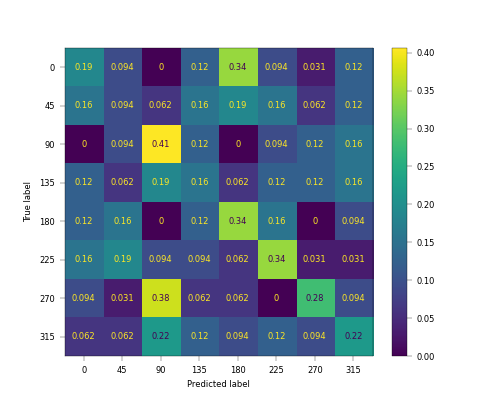

In [341]:
skmetrics.plot_confusion_matrix(trained_svc, test_data, test_labels, 
                                normalize='true')  

In [11]:
def wraper_func(func, **kwargs):
    output = func(**kwargs)
    return output

In [20]:
def func1(x='Func1', y='Alt1', z='Extra1'):
    res = '%s_%s_%s' % (x, y, z)
    return res

def func2(x='Func2', y='Alt2', w='Extra2'):
    res = '%s_%s_%s' % (x, y, z)
    r2 = 'andthis'
    return res, r2

In [23]:
inargs = {'x': 'check1', 'z': 'check2'}
inargs = (x='check1', y='check2')
res = wraper_func(func1, **inargs)
res

SyntaxError: invalid syntax (<ipython-input-23-0a6f99e4a23c>, line 2)

In [22]:
res = wraper_func(func2, **inargs)
res

TypeError: func2() got an unexpected keyword argument 'z'

In [ ]:
decode_from_fov(dk, va, neuraldf, sdf, C_value=C_value,
                        n_iterations=n_iterations, n_processes=n_processes, results_id=results_id,
                        class_a=class_a, class_b=class_b, do_shuffle=do_shuffle,
                        rootdir=rootdir, verbose=verbose,
                        test_type=test_type, n_train_configs=n_train_configs) 
            print("--- done by_fov ---")